In [1]:
# Run time of the code
import time
tot_start = time.time()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Linear regression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score

# Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras import regularizers
from itertools import product

# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

---

<h1><b><center>Analysis of EV Charging Data to Predict Optimal Charging Duration</b></h1>
<h2><center>Group 48</h2>

---

---

<h1><center>Performance Metric</h1>

---

Since we are working with a regression problem, we will use R2 as our performance metric. For our logistic regression comparison section, we will use accuracy. 

---

<h1><center>Data Pre-Processing</h1>

---

<h3><center>Clean and Inspect the Data</h3>

In [3]:
# Set a random seed to maintain consistent results
rand_seed = 873465

In [52]:
# Import data
# Data from: https://www.kaggle.com/datasets/ziya07/ev-battery-charging-data/data
df = pd.read_csv('data/ev_battery_charging_data.csv')

In [5]:
# Drop rows with any NaN values
df_clean = df.dropna()

# Shape after cleaning
print("After removing rows with NaN:")
print(f"Rows: {df_clean.shape[0]}, Columns: {df_clean.shape[1]}")

After removing rows with NaN:
Rows: 1000, Columns: 13


In [6]:
# Drop inputs calculated from the column we are predicting
drop_cols = ['Degradation Rate (%)', 'Efficiency (%)', 'Optimal Charging Duration Class']
df_clean = df_clean.drop(columns=drop_cols)

In [7]:
# List the categorical columns and numerical columns for later pre-processing steps
cat_col = ['Charging Mode', 'Battery Type', 'EV Model']
num_col = ['SOC (%)', 'Voltage (V)', 'Current (A)', 'Battery Temp (°C)', 'Ambient Temp (°C)', 'Charging Cycles']
target = 'Charging Duration (min)'

In [8]:
# Move the column we are predicting to the end to maintain consistent format
df_clean[target] = df_clean.pop(target)

In [9]:
# Inspect the data
df_clean.head()

,SOC (%),Voltage (V),Current (A),Battery Temp (°C),Ambient Temp (°C),Charging Mode,Battery Type,Charging Cycles,EV Model,Charging Duration (min)
0,43.708611,3.629593,33.553512,33.454060,26.439918,Fast,Li-ion,112,Model B,59.363552
1,95.564288,3.879331,32.228092,35.933628,31.108647,Fast,LiFePO4,398,Model A,67.343566
2,75.879455,4.111062,91.562912,25.009358,30.203219,Slow,LiFePO4,175,Model A,105.454739
3,63.879264,4.012557,32.459158,32.497482,18.077998,Fast,LiFePO4,150,Model B,54.000439
4,24.041678,4.064593,34.475475,31.434920,17.984989,Fast,Li-ion,886,Model C,106.964968


In [10]:
df_clean.describe(include='all')

,SOC (%),Voltage (V),Current (A),Battery Temp (°C),Ambient Temp (°C),Charging Mode,Battery Type,Charging Cycles,EV Model,Charging Duration (min)
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000,1000,1000.000000,1000,1000.000000
unique,NaN,NaN,NaN,NaN,NaN,3,2,NaN,3,NaN
top,NaN,NaN,NaN,NaN,NaN,Slow,LiFePO4,NaN,Model C,NaN
freq,NaN,NaN,NaN,NaN,NaN,341,503,NaN,343,NaN
mean,54.123090,3.854912,55.216515,29.807501,24.882106,NaN,NaN,556.560000,NaN,69.846449
std,26.292363,0.204533,26.160678,5.729787,5.736199,NaN,NaN,263.763052,NaN,28.919481
min,10.416882,3.502253,10.001047,20.013068,15.000614,NaN,NaN,101.000000,NaN,20.618382
25%,31.237594,3.668752,33.521588,24.838015,19.899480,NaN,NaN,317.750000,NaN,44.938000
50%,54.712664,3.863114,55.055253,29.685586,24.891962,NaN,NaN,571.000000,NaN,69.040282
75%,76.988763,4.032326,78.319317,34.750816,29.799869,NaN,NaN,786.000000,NaN,93.985178


<h3><center>Create Train, Validate, and Test Datasets</h3>

In [11]:
# Split the data into train, test, and validate
X = df_clean.drop(columns=target)
y = df_clean[target]

# Test data is 20% of total
Xtrain_valid, Xtest, ytrain_valid, ytest = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

# Train data is 70% of total and validate data is 10% of total
Xtrain, Xvalid, ytrain, yvalid = train_test_split(Xtrain_valid, ytrain_valid, test_size=0.125, random_state=rand_seed)

<h3><center>Scale Numerical Data and One-Hot Encode Categorical Data</h3>

In [12]:
# Preprocessor for numerical columns
num_transformer = Pipeline(
    steps=[("scaler", StandardScaler())])

# Preprocessor for categorical columns
cat_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(drop='first'))])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_col),
        ('cat', cat_transformer, cat_col)])

In [13]:
# Fit the preprocessor with the training data and apply to the training, validation, and testing data
Xtrain_norm = preprocessor.fit_transform(Xtrain)
Xvalid_norm = preprocessor.transform(Xvalid)
Xtest_norm = preprocessor.transform(Xtest)

# Convert to data frames for the neural network models
feature_names_x = preprocessor.get_feature_names_out()

Xtrain_norm_df = pd.DataFrame(Xtrain_norm, columns=feature_names_x, index=Xtrain.index)
Xvalid_norm_df = pd.DataFrame(Xvalid_norm, columns=feature_names_x, index=Xvalid.index)
Xtest_norm_df = pd.DataFrame(Xtest_norm, columns=feature_names_x, index=Xtest.index)

ytrain_df = pd.DataFrame(ytrain)
yvalid_df = pd.DataFrame(yvalid)
ytest_df = pd.DataFrame(ytest)

---

<h1><center>Train and Evaluate Models</h1>

---

In [14]:
# Make a dictionary to store the best results of each family of models. The logistic regression 
# comparison is left out since it uses accuracy instead of R2. The best logistic regression model and 
# the best regression model (out of linear regression, neural networks, and random forest) will both 
# be evaluated with the test data at the end. 
best_results = []

---

<h1><center>Linear Regression Models</h1>

---

<h3><center>Linear Regression with Feature Selection</h3>

In [15]:
# Linear regression with feature selection

# There are 11 features in the cleaned data, so 11 models are made. Scikit-learn's SequentialFeatureSelector is used. 

# --- SequentialFeatureSelector Description ---
# SequentialFeatureSelector works like the forward feature selection done in Lab 4 since the direction selected is 
# 'forward'. It starts with one feature and makes models, and then choses the best model based on a cross 
# validation score. It then adds one more feature and keeps the features that maximize the cross validation score. It 
# repeats this until it reaches the desired number of features, which is given in n_features_to_select. 

linreg_models = []

for i in range(1, Xtrain_norm.shape[1]):
    linreg_pipe = Pipeline([('forward_selection', SequentialFeatureSelector(estimator=LinearRegression(),
                                                                            n_features_to_select=i,
                                                                            direction='forward',
                                                                            scoring='r2',
                                                                            cv=8)),
                            ('linreg', LinearRegression())])
    linreg_pipe.fit(Xtrain_norm, ytrain)

    features = feature_names_x[linreg_pipe.named_steps['forward_selection'].support_]
    
    train_r2 = linreg_pipe.score(Xtrain_norm, ytrain)
    val_r2 = np.mean(cross_val_score(linreg_pipe, Xtrain_norm, ytrain, scoring='r2', cv=8))
    
    linreg_models.append({'Model Name': 'Linear Regression with Feature Selection',
                          'Model': linreg_pipe,
                          'Parameters': {'Number of Features': i, 'Feature Names': features},
                          'Train R2': train_r2,
                          'Validate R2': val_r2})

# Add in a linear regression model with all the features
linreg_pipe = Pipeline([('linreg', LinearRegression())])
linreg_pipe.fit(Xtrain_norm, ytrain)

train_r2 = linreg_pipe.score(Xtrain_norm, ytrain)
val_r2 = np.mean(cross_val_score(linreg_pipe, Xtrain_norm, ytrain, scoring='r2', cv=8))

linreg_models.append({'Model Name': 'Linear Regression with Feature Selection',
                      'Model': linreg_pipe,
                      'Parameters': {'Number of Features': 11, 'Feature Names': feature_names_x},
                      'Train R2': train_r2,
                      'Validate R2': val_r2})

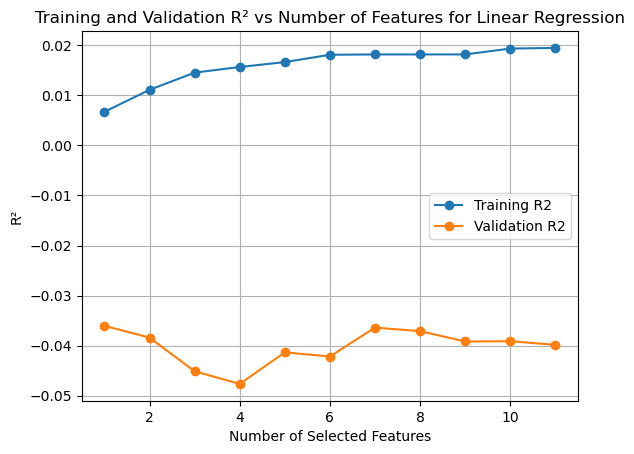

In [16]:
# Plot of training R2 and validation R2 vs number of features for linear regression with feature selection
num_features = [temp['Parameters']['Number of Features'] for temp in linreg_models]
train_r2s = [temp['Train R2'] for temp in linreg_models]
val_r2s = [temp['Validate R2'] for temp in linreg_models]

plt.plot(num_features, train_r2s, label='Training R2', marker='o')
plt.plot(num_features, val_r2s, label='Validation R2', marker='o')
plt.title('Training and Validation R² vs Number of Features for Linear Regression')
plt.xlabel('Number of Selected Features')
plt.ylabel('R²')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

In [17]:
# Add the best model to the main results dictionary
idx = np.argmax(val_r2s)
best_results.append(linreg_models[idx])
print('The best model for linear regression with feature selection')
print(f'Training R²: {train_r2s[idx]:.3}')
print(f'Validation R²: {val_r2s[idx]:.3}')
print(f'Number of Features: {num_features[idx]}')
features = [temp['Parameters']['Feature Names'] for temp in linreg_models]
print(f'Name of the Feature(s): {", ".join(features[idx])}')

The best model for linear regression with feature selection
Training R²: 0.00673
Validation R²: -0.0361
Number of Features: 1
Name of the Feature(s): cat__EV Model_Model B


<h3><center>Lasso Regression</h3>

In [18]:
# Lasso regression

# The alpha range was found by testing a number of different ranges

alphas = np.logspace(-2, 1, 10)
lasso_models = []

for alpha in alphas:
    lasso_pipe = Pipeline([('lasso', Lasso(alpha=alpha, max_iter=10000))])
    lasso_pipe.fit(Xtrain_norm, ytrain)

    train_r2 = lasso_pipe.score(Xtrain_norm, ytrain)
    val_r2 = np.mean(cross_val_score(lasso_pipe, Xtrain_norm, ytrain, scoring='r2', cv=8))
    
    lasso_models.append({'Model Name': 'Linear Regression',
                         'Model': lasso_pipe,
                         'Parameters': {'Alpha': alpha},
                         'Train R2': train_r2,
                         'Validate R2': val_r2})

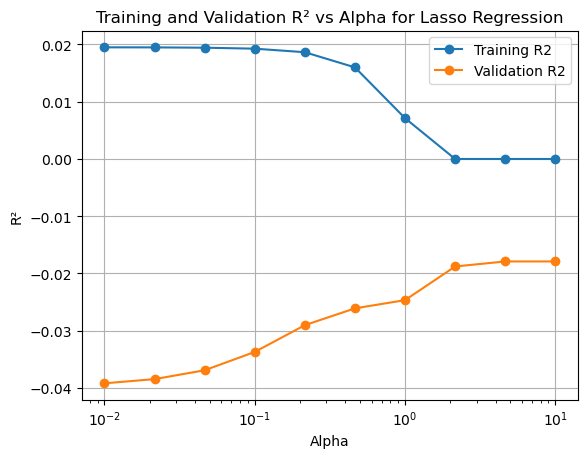

In [53]:
# Plot of training R2 and validation R2 vs number of features for linear regression with feature selection
alpha = [temp['Parameters']['Alpha'] for temp in lasso_models]
train_r2s = [temp['Train R2'] for temp in lasso_models]
val_r2s = [temp['Validate R2'] for temp in lasso_models]

plt.semilogx(alpha, train_r2s, label='Training R2', marker='o')
plt.semilogx(alpha, val_r2s, label='Validation R2', marker='o')
plt.title('Training and Validation R² vs Alpha for Lasso Regression')
plt.xlabel('Alpha')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Add the best model to the main results dictionary
idx = np.argmax(val_r2s)
best_results.append(lasso_models[idx])
print('The best model for lasso regression')
print(f'Training R²: {train_r2s[idx]:.3}')
print(f'Validation R²: {val_r2s[idx]:.3}')
print(f'Alpha: {alpha[idx]:.3}')

The best model for lasso regression
Training R²: 0.0
Validation R²: -0.0179
Alpha: 4.64


---

<h1><center>Logistic Regression Comparison</h1>

---

In [21]:
# This is a completely difference problem since it is classificcation instead of regression. The goal is 
# to compare the logistic regression and linear regression models with feature selection. First, we switch the 
# target column from numerical to categorical. To maintain consistant training, validation, and testing 
# datasets, the target column is split using pd.cut instead of using the orignal feature. 
ytrain_log = pd.cut(ytrain, bins=[0, 40, 80, np.inf], labels=[0, 1, 2,]).astype(int)
ytest_log = pd.cut(ytest, bins=[0, 40, 80, np.inf], labels=[0, 1, 2,]).astype(int)

In [22]:
# Calculate the baseline accuracy
counts = np.bincount(ytrain_log)
baseline = np.max(counts/len(ytrain_log))
print(f'Baseline accuracy: {baseline:.3}')

Baseline accuracy: 0.414


In [23]:
# Logistic regression with feature selection

# There are 11 features in the cleaned data, so 11 models are made. Scikit-learn's SequentialFeatureSelector is used. The 
# description of how this works is in the linear regression section and in the final report. 

# Since there are three categories, Scikit-learn's LogisticRegression will automatically switch to use softmax (no extra inputs). 

logreg_models = []

for i in range(1, Xtrain_norm.shape[1]):
    logreg_pipe = Pipeline([('forward_selection', SequentialFeatureSelector(estimator=LogisticRegression(),
                                                                               n_features_to_select=i,
                                                                               direction='forward',
                                                                               scoring='accuracy',
                                                                               cv=8)),
                            ('logreg', LogisticRegression())])
    logreg_pipe.fit(Xtrain_norm, ytrain_log)

    features = feature_names_x[logreg_pipe.named_steps['forward_selection'].support_]
    
    train_acc = logreg_pipe.score(Xtrain_norm, ytrain_log)
    val_acc = np.mean(cross_val_score(logreg_pipe, Xtrain_norm, ytrain_log, cv=8))
    
    logreg_models.append({'Model Name': 'Logistic Regression with Feature Selection',
                          'Model': logreg_pipe,
                          'Parameters': {'Number of Features': i, 'Feature Names': features},
                          'Train Accuracy': train_acc,
                          'Validate Accuracy': val_acc})

# Add in a linear regression model with all the features
logreg_pipe = Pipeline([('logreg', LogisticRegression())])
logreg_pipe.fit(Xtrain_norm, ytrain_log)

train_acc = logreg_pipe.score(Xtrain_norm, ytrain_log)
val_acc = np.mean(cross_val_score(logreg_pipe, Xtrain_norm, ytrain_log, cv=8))

logreg_models.append({'Model Name': 'Logistic Regression with Feature Selection',
                      'Model': logreg_pipe,
                      'Parameters': {'Number of Features': 11, 'Feature Names': feature_names_x},
                      'Train Accuracy': train_acc,
                      'Validate Accuracy': val_acc})

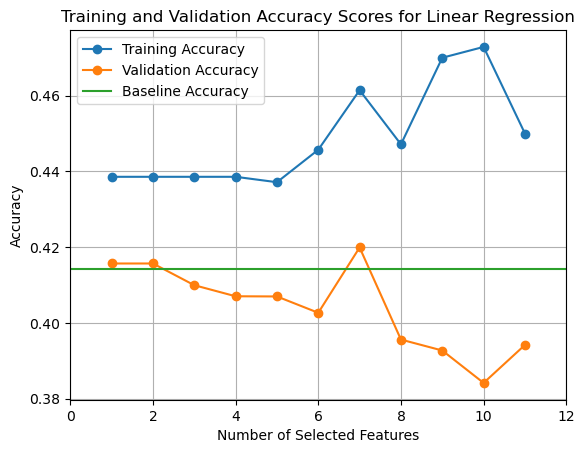

In [24]:
# Plot of training accuracy and validation accuracy vs number of features for logistic regression with feature selection
num_features = [temp['Parameters']['Number of Features'] for temp in logreg_models]
train_accs = [temp['Train Accuracy'] for temp in logreg_models]
val_accs = [temp['Validate Accuracy'] for temp in logreg_models]

plt.plot(num_features, train_accs, label='Training Accuracy', marker='o')
plt.plot(num_features, val_accs, label='Validation Accuracy', marker='o')
plt.plot( [0, 12], [baseline, baseline], label='Baseline Accuracy')
plt.title('Training and Validation Accuracy Scores for Linear Regression')
plt.xlabel('Number of Selected Features')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim(0, 12)
plt.grid(True)
plt.show()

In [25]:
# Find the best logistic regression model
idx = np.argmax(val_accs)
print('The best model for logistic regression with feature selection')
print(f'Training Accuracy: {train_accs[idx]:.3}')
print(f'Validation Accuracy: {val_accs[idx]:.3}')
print(f'Number of Features: {num_features[idx]}')
features = [temp['Parameters']['Feature Names'] for temp in logreg_models]
print(f'Name of the Feature(s): {", ".join(features[idx])}')

The best model for logistic regression with feature selection
Training Accuracy: 0.461
Validation Accuracy: 0.42
Number of Features: 7
Name of the Feature(s): num__SOC (%), num__Voltage (V), num__Ambient Temp (°C), num__Charging Cycles, cat__Charging Mode_Normal, cat__Charging Mode_Slow, cat__EV Model_Model B


---

<h1><center>Neural Networks

---

Plan:<br>
1. Build a basic NN to get results<br>
    a. Build pipeline<br>
    b. Build NN model<br>
    c. Compile NN w/ pipeline<br>
    d. Calculate R2 score and compare with linreg<br>
2. Build function to build pipelines

In [26]:
# Build an MLP

ki = GlorotUniform(seed=2434)

model_mlp = Sequential([
    Dense(64, input_shape=(Xtrain_norm_df.shape[1],), activation='relu', kernel_initializer=ki),
    Dense(32, activation='relu', kernel_initializer=ki),
    Dense(16, activation='relu', kernel_initializer=ki),
    Dense(1, kernel_initializer=ki)
])

model_mlp.compile( optimizer="rmsprop", loss="mse", metrics=["r2_score"] )

C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# Train the MLP

history_mlp = model_mlp.fit(x=Xtrain_norm_df, y=ytrain_df, epochs=50, validation_data=(Xvalid_norm_df,yvalid_df))

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5549.0513 - r2_score: -5.7809 - val_loss: 5566.8789 - val_r2_score: -6.3296
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4970.7334 - r2_score: -5.0742 - val_loss: 4830.7363 - val_r2_score: -5.3603
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4051.0562 - r2_score: -3.9503 - val_loss: 3717.2905 - val_r2_score: -3.8943
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2832.0115 - r2_score: -2.4607 - val_loss: 2396.3896 - val_r2_score: -2.1552
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1681.3762 - r2_score: -1.0546 - val_loss: 1419.5530 - val_r2_score: -0.8690
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1121.5121 - r2_score: -0.3705 - val_loss: 1115.1284 - val_r2_score: -0.4682
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1016.2850 - r2_score: -0.2419 - val_loss: 1067.8202 - val_r2_score: -0.4059
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 981

In [28]:
mlp_perf = r2_score(ytrain_df, model_mlp.predict(Xtrain_norm_df))
mlp_perf_valid = r2_score(yvalid_df, model_mlp.predict(Xvalid_norm_df))
print(mlp_perf)
print(mlp_perf_valid)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
0.06805545091629028
-0.1981513500213623


In [29]:
def build_model(num_layers, x_data, last_reg_layer, lr=0.01,):

    num_units = np.zeros(num_layers, dtype=int)
    num_units[-1] = 1
    if num_layers > 1:
        for i in range(num_layers-1):
            num_units[i] = 2**(num_layers+1-i)

    layers = []
    ki = GlorotUniform(seed=2434)
    layers.append(Dense(num_units[0], input_shape=(x_data.shape[1],), activation='relu', kernel_initializer=ki))
    for i in range(1, num_layers-1):
        layers.append(Dense(num_units[i], activation='relu', kernel_initializer=ki))
    layers.append(Dense(1, kernel_initializer=ki, kernel_regularizer=last_reg_layer))


    model = Sequential(layers)

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

    model.compile( optimizer=optimizer, loss="mse", metrics=["r2_score"] )

    return model

In [30]:
param_grid = {
    'num_layers': [2, 3, 4, 5],
    'last_reg_layer': [None, regularizers.l1(1e-2),
                       regularizers.l1(1e-1),
                       regularizers.l2(1e-2), regularizers.l2(1e-1)],
    'epochs': [10, 25, 50]
}


In [31]:
all_combos = list(product(
    param_grid['num_layers'],
    param_grid['last_reg_layer'],
    param_grid['epochs']   
))

In [32]:
def reg_to_str(reg):
    if reg is None:
        return "None"
    elif hasattr(reg, 'l1'):
        return f"L1({reg.l1:.3f})"   # rounds to 3 decimals
    elif hasattr(reg, 'l2'):
        return f"L2({reg.l2:.3f})"
    else:
        return str(reg)


In [33]:
results = []

for num_layers, last_reg_layer, epochs in all_combos:

    model = build_model(num_layers, Xtrain_norm_df, last_reg_layer)

    history = model.fit(
        x = Xtrain_norm_df,
        y = ytrain_df,
        epochs=epochs,
        validation_data = (Xvalid_norm_df, yvalid_df),
        verbose=0
    )

    y_hat_valid = model.predict(Xvalid_norm_df)
    perf_valid = r2_score(yvalid_df, y_hat_valid)

    y_hat_train = model.predict(Xtrain_norm_df)
    perf_train = r2_score(ytrain_df, y_hat_train)

    results.append({
    'num_layers': num_layers,
    'last_reg_layer': reg_to_str(last_reg_layer),
    'epochs': epochs,
    'r2_train': perf_train,
    'r2_valid': perf_valid,
    'model': model,
    })

results_df = pd.DataFrame(results)

print(results_df.head())


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ec8to\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
   num_layers last_reg_layer  epochs  r2_train  r2_valid  \
0           2           None      10 -0.373925 -0.560744   
1           2           None      25 -0.093801 -0.212873   
2           2           None      50  0.013832 -0.057500   
3           2      L1(0.010)      10 -0.384271 -0.581899   
4           2      L1(0.010)      25 -0.098927 -0.214120   

                                        model  
0  <Sequential name=sequential_1, built=True>  
1  <Sequential name=sequential_2, built=True>  
2  <Sequential name=sequential_3, built=True>  
3  <Sequential name=sequential_4, built=True>  
4  <Sequential name=sequential_5, built=True>  


In [34]:
results_df['last_reg_layer'] = results_df['last_reg_layer'].fillna("None")
results_df

,num_layers,last_reg_layer,epochs,r2_train,r2_valid,model
0,2,None,10,-0.373925,-0.560744,"<Sequential name=sequential_1, built=True>"
1,2,None,25,-0.093801,-0.212873,"<Sequential name=sequential_2, built=True>"
2,2,None,50,0.013832,-0.057500,"<Sequential name=sequential_3, built=True>"
3,2,L1(0.010),10,-0.384271,-0.581899,"<Sequential name=sequential_4, built=True>"
4,2,L1(0.010),25,-0.098927,-0.214120,"<Sequential name=sequential_5, built=True>"
5,2,L1(0.010),50,0.016060,-0.060378,"<Sequential name=sequential_6, built=True>"
6,2,L1(0.100),10,-0.374855,-0.564712,"<Sequential name=sequential_7, built=True>"
7,2,L1(0.100),25,-0.098461,-0.209535,"<Sequential name=sequential_8, built=True>"
8,2,L1(0.100),50,0.013593,-0.068502,"<Sequential name=sequential_9, built=True>"
9,2,L2(0.010),10,-0.368526,-0.569915,"<Sequential name=sequential_10, built=True>"


In [35]:
best_model_NN_idx = results_df['r2_valid'].idxmax()
best_model_NN = results_df.loc[best_model_NN_idx]
best_model_NN

num_layers                                                  2
last_reg_layer                                      L2(0.100)
epochs                                                     50
r2_train                                             0.015423
r2_valid                                            -0.039534
model             <Sequential name=sequential_15, built=True>
Name: 14, dtype: object

In [36]:
best_model_NN_idx_train = results_df['r2_train'].idxmax()
worst_model_NN_idx = results_df['r2_valid'].idxmin()
worst_model_NN_idx_train = results_df['r2_train'].idxmin()

best_model_NN_train = results_df.loc[best_model_NN_idx_train]
worst_model_NN = results_df.loc[worst_model_NN_idx]
worst_model_NN_train = results_df.loc[worst_model_NN_idx_train]

best_model_NN_train

num_layers                                                  5
last_reg_layer                                      L1(0.100)
epochs                                                     50
r2_train                                             0.479959
r2_valid                                            -0.506396
model             <Sequential name=sequential_54, built=True>
Name: 53, dtype: object

In [37]:
worst_model_NN

num_layers                                                 2
last_reg_layer                                     L1(0.010)
epochs                                                    10
r2_train                                           -0.384271
r2_valid                                           -0.581899
model             <Sequential name=sequential_4, built=True>
Name: 3, dtype: object

In [38]:
worst_model_NN_train

num_layers                                                 2
last_reg_layer                                     L1(0.010)
epochs                                                    10
r2_train                                           -0.384271
r2_valid                                           -0.581899
model             <Sequential name=sequential_4, built=True>
Name: 3, dtype: object

In [39]:
param_names = list(param_grid.keys())
sweeps = []

for i in param_names:
    list_param_values = sorted(results_df[i].unique())
    param_names_copy = [p for p in param_names if p != i]

    sweep = results_df[
        (results_df[param_names_copy[0]] == best_model_NN[param_names_copy[0]]) &
        (results_df[param_names_copy[1]] == best_model_NN[param_names_copy[1]]) 
    ]
    sweeps.append(sweep)


In [40]:
nn_model_best = ({'Model Name': 'Neural Network',
                  'Model': best_model_NN['model'],
                  'Parameters': {'Layers': best_model_NN['num_layers'], 'Regularization': best_model_NN['last_reg_layer'], 'Epochs': best_model_NN['epochs']},
                  'Train R2': best_model_NN['r2_train'],
                  'Validate R2': best_model_NN['r2_valid']})
best_results.append(nn_model_best)
sweeps

[    num_layers last_reg_layer  epochs  r2_train  r2_valid  \
 14           2      L2(0.100)      50  0.015423 -0.039534   
 29           3      L2(0.100)      50  0.101667 -0.130739   
 44           4      L2(0.100)      50  0.093401 -0.492546   
 59           5      L2(0.100)      50  0.444170 -0.463432   
 
                                           model  
 14  <Sequential name=sequential_15, built=True>  
 29  <Sequential name=sequential_30, built=True>  
 44  <Sequential name=sequential_45, built=True>  
 59  <Sequential name=sequential_60, built=True>  ,
     num_layers last_reg_layer  epochs  r2_train  r2_valid  \
 2            2           None      50  0.013832 -0.057500   
 5            2      L1(0.010)      50  0.016060 -0.060378   
 8            2      L1(0.100)      50  0.013593 -0.068502   
 11           2      L2(0.010)      50  0.015683 -0.047186   
 14           2      L2(0.100)      50  0.015423 -0.039534   
 
                                           model  
 2    <

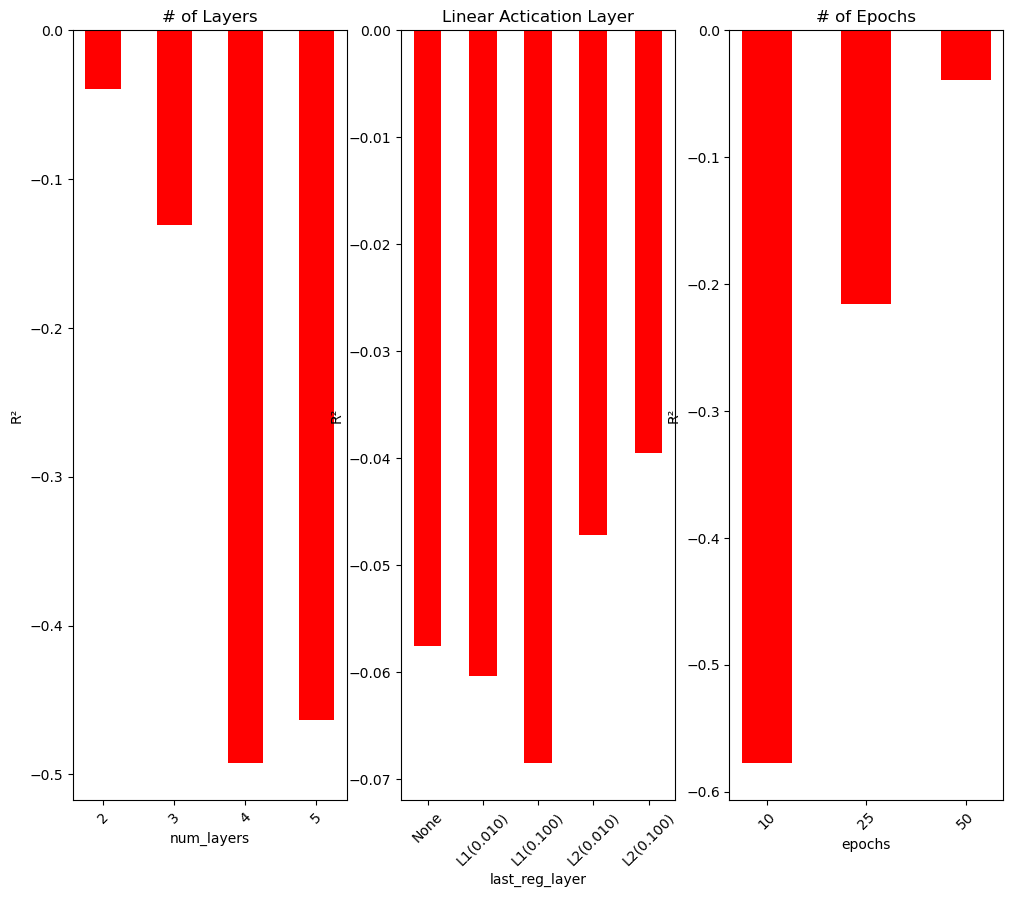

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(12, 10))
axes = axes.flatten()
bar_width = 0.5
names = ['# of Layers', 'Linear Actication Layer', '# of Epochs']

for idx, sweep in enumerate(sweeps):
    x_vals = sweep[param_names[idx]]
    y_vals = sweep['r2_valid']
    positions = np.arange(len(x_vals))
    
    axes[idx].bar(positions, y_vals, width=bar_width, color='red')
    axes[idx].set_xticks(positions)
    axes[idx].set_xticklabels(x_vals, rotation=45)
    axes[idx].set_title(names[idx])
    axes[idx].set_ylabel("R²")
    axes[idx].set_xlabel(param_names[idx])

plt.subplots_adjust(hspace=0.35)



---

<h1><center>Random Forest

---

In [42]:
#RF_1, RF_2, RF_3: increasing n_estimators (50, 100, 200)
#RF_4: regularized trees (shallower trees, min leaf = 5)
#RF_5: strongly regularized trees (more trees, deeper but min leaf = 10)

rf_configs = {
    'RF_1 (50 trees)': RandomForestRegressor(
        n_estimators=50,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=rand_seed,
        n_jobs=-1
    ),
    'RF_2 (100 trees)': RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=rand_seed,
        n_jobs=-1
    ),
    'RF_3 (200 trees)': RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=rand_seed,
        n_jobs=-1
    ),
    'RF_4 (100 trees, depth=10, leaf=5)': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=5,
        random_state=rand_seed,
        n_jobs=-1
    ),
    'RF_5 (300 trees, depth=15, leaf=10)': RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=2,
        min_samples_leaf=10,
        random_state=rand_seed,
        n_jobs=-1
    ),
}

In [43]:
rf_results = []
rf_fitted_models = {}

for name, model in rf_configs.items():
    #Training the model and recording training time
    start = time.time()
    model.fit(Xtrain_norm_df, ytrain_df.values.ravel())
    train_time = time.time() - start
    
    #Saving the fitted model
    rf_fitted_models[name] = model

    #Get predictions on train and validation sets
    ytrain_pred = model.predict(Xtrain_norm_df)
    yvalid_pred = model.predict(Xvalid_norm_df)

    #Computing performance metrics
    train_r2 = r2_score(ytrain_df, ytrain_pred)
    valid_r2 = r2_score(yvalid_df, yvalid_pred)
    valid_mae = mean_absolute_error(yvalid_df, yvalid_pred)
    valid_rmse = np.sqrt(mean_squared_error(yvalid_df, yvalid_pred))

    #Storing the results
    rf_results.append({
        'Model': name,
        'n_estimators': model.n_estimators,
        'max_depth': model.max_depth,
        'min_samples_leaf': model.min_samples_leaf,
        'Train R²': train_r2,
        'Valid R²': valid_r2,
        'Valid MAE': valid_mae,
        'Valid RMSE': valid_rmse,
        'Train Time (s)': train_time
    })

rf_results_df = pd.DataFrame(rf_results)
rf_results_df.head()

,Model,n_estimators,max_depth,min_samples_leaf,Train R²,Valid R²,Valid MAE,Valid RMSE,Train Time (s)
0,RF_1 (50 trees),50,NaN,1,0.847538,0.025333,22.680006,27.207897,0.121535
1,RF_2 (100 trees),100,NaN,1,0.855457,0.045161,22.617864,26.929724,0.211940
2,RF_3 (200 trees),200,NaN,1,0.858645,0.035131,22.760025,27.070793,0.350659
3,"RF_4 (100 trees, depth=10, leaf=5)",100,10.0,5,0.514347,0.035200,22.699268,27.069827,0.166715
4,"RF_5 (300 trees, depth=15, leaf=10)",300,15.0,10,0.368855,0.017811,22.894023,27.312680,0.426383


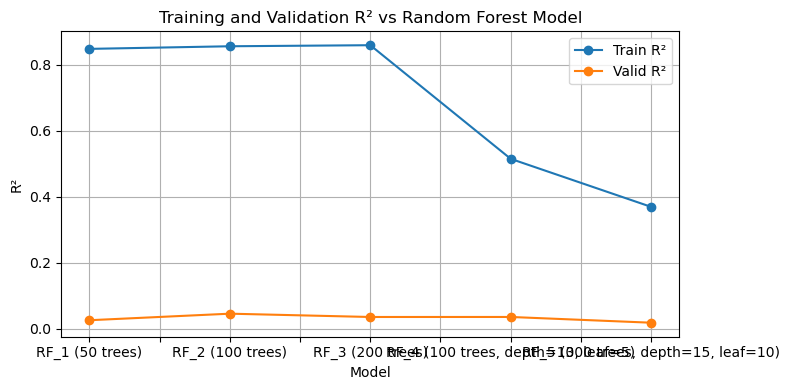

In [44]:
#Plotting train_r2, valid_r2
rf_results_df.plot(
    x='Model',
    y=['Train R²', 'Valid R²'],
    marker='o',
    figsize=(8, 4),
    title='Training and Validation R² vs Random Forest Model'
)
plt.ylabel("R²")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
#Selecting model with highest validation R²
best_rf_row = rf_results_df.loc[rf_results_df['Valid R²'].idxmax()]
best_rf_name = best_rf_row['Model']
best_rf = rf_fitted_models[best_rf_name]

print("Best RF model (based on validation R²):")
display(best_rf_row[['Model', 'n_estimators', 'max_depth', 'min_samples_leaf', 
                     'Train R²', 'Valid R²', 'Valid MAE', 'Valid RMSE', 'Train Time (s)']])

Best RF model (based on validation R²):


Model               RF_2 (100 trees)
n_estimators                     100
max_depth                        NaN
min_samples_leaf                   1
Train R²                    0.855457
Valid R²                    0.045161
Valid MAE                  22.617864
Valid RMSE                 26.929724
Train Time (s)               0.21194
Name: 1, dtype: object

In [46]:
#Computing feature importances for all engineered features
importances = best_rf.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names_x,
    'Importance': importances
}).sort_values('Importance', ascending=False)

feat_imp_df

,Feature,Importance
5,num__Charging Cycles,0.169188
1,num__Voltage (V),0.159962
2,num__Current (A),0.154385
4,num__Ambient Temp (°C),0.152595
0,num__SOC (%),0.143913
3,num__Battery Temp (°C),0.135620
9,cat__EV Model_Model B,0.019597
6,cat__Charging Mode_Normal,0.017265
8,cat__Battery Type_LiFePO4,0.015947
7,cat__Charging Mode_Slow,0.015801


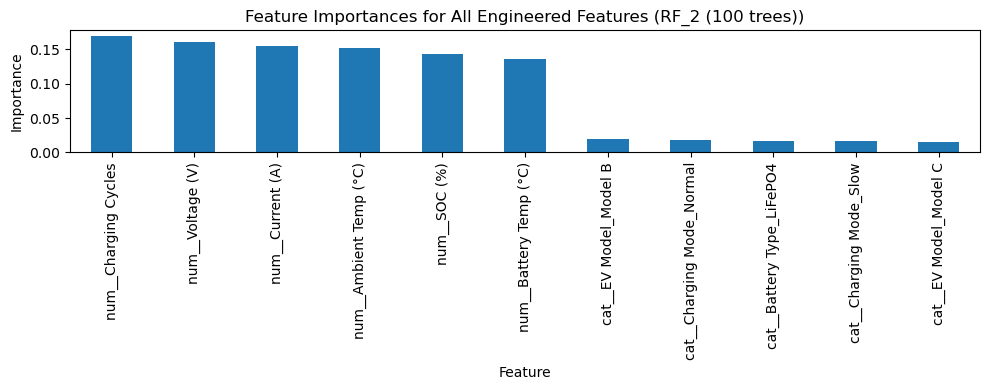

In [47]:
#Plotting feature importances for ALL engineered features
feat_imp_df.plot(
    x='Feature',
    y='Importance',
    kind='bar',
    figsize=(10, 4),
    legend=False
)
plt.ylabel("Importance")
plt.title(f"Feature Importances for All Engineered Features ({best_rf_name})")
plt.tight_layout()
plt.show()

In [48]:
rf_best_idx = np.argmax(rf_results_df['Valid R²'])
rf_best = rf_results_df.loc[rf_best_idx]

rf_model_best = ({'Model Name': 'Random Forest',
                  'Model': rf_fitted_models[rf_best['Model']],
                  'Parameters': {'# of Trees': rf_best['n_estimators'], '# of Leaves': rf_best['min_samples_leaf']},
                  'Train R2': rf_best['Train R²'],
                  'Validate R2': rf_best['Valid R²']})
best_results.append(rf_model_best)

---

<h1><center>Best Model and Evaluation with the Test Data</h1>

---

In [49]:
# First we use the test data to evaluate the best logistic regression model since this is a separate problem 
# and will not be directly compared to the scores of the other regression models. 

train_accs = [temp['Train Accuracy'] for temp in logreg_models]
val_accs = [temp['Validate Accuracy'] for temp in logreg_models]
idx = np.argmax(val_accs)
print('The best model of Logistic Regression')
print(f'Baseline accuracy: {baseline:.3}')
print(f'Training accuracy: {train_accs[idx]:.3}')
print(f'Validation accuracy: {val_accs[idx]:.3}')

# Evaluate with the test data
models = [temp['Model'] for temp in logreg_models]
best_logreg_model = models[idx]
best_logreg_pred = best_logreg_model.predict(Xtest_norm)
test_acc = accuracy_score(ytest_log, best_logreg_pred)
print(f'Test accuracy: {test_acc:.3}')

The best model of Logistic Regression
Baseline accuracy: 0.414
Training accuracy: 0.461
Validation accuracy: 0.42
Test accuracy: 0.395


In [50]:
# Now we find the overall best regression model from from each family's best model. Finding the best validation 
# R2 score will give the best model. 

model_names = [temp['Model Name'] for temp in best_results]
train_r2s = [temp['Train R2'] for temp in best_results]
val_r2s = [temp['Validate R2'] for temp in best_results]
idx = np.argmax(val_r2s)
print(f'The best regression model is {"".join(model_names[idx])}')
print(f'Training R²: {train_r2s[idx]:.3}')
print(f'Validation R²: {val_r2s[idx]:.3}')

# Evaluate with the test data
models = [temp['Model'] for temp in best_results]
best_model = models[idx]
best_pred = best_model.predict(Xtest_norm)
test_r2 = r2_score(ytest, best_pred)
print(f'Test R²: {test_r2:.3}')

The best regression model is Random Forest
Training R²: 0.855
Validation R²: 0.0452
Test R²: -0.0535


C:\Users\ec8to\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [51]:
# Total run time
tot_time = time.time() - tot_start
print(tot_time)

601.587539434433
